In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import openml
from category_encoders import LeaveOneOutEncoder, CatBoostEncoder
import matplotlib.pyplot as plt

import pycaret
from pycaret.classification import ClassificationExperiment
from pycaret.datasets import get_data

from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split

from ydata_profiling import ProfileReport

from earlymed import LearningCurve, FeatureCurve, FeatureLearningPlot

In [2]:
full_data = openml.datasets.get_dataset(15).get_data()[0]
full_data.shape

(699, 10)

In [3]:
data, _ = train_test_split(full_data, train_size=200, random_state=42)

In [4]:
profile = ProfileReport(data, title="Pandas Profiling Report")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 186 to 102
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Clump_Thickness        200 non-null    float64 
 1   Cell_Size_Uniformity   200 non-null    float64 
 2   Cell_Shape_Uniformity  200 non-null    float64 
 3   Marginal_Adhesion      200 non-null    float64 
 4   Single_Epi_Cell_Size   200 non-null    float64 
 5   Bare_Nuclei            198 non-null    float64 
 6   Bland_Chromatin        200 non-null    float64 
 7   Normal_Nucleoli        200 non-null    float64 
 8   Mitoses                200 non-null    float64 
 9   Class                  200 non-null    category
dtypes: category(1), float64(9)
memory usage: 15.9 KB


In [6]:
n_classes = data['Class'].unique().size

---
### CatBoostEncoder

In [7]:
exp = ClassificationExperiment()
exp.setup(
    data,
    target='Class',
    session_id=42,
    preprocess=True,
    imputation_type='simple',
    normalize=True,
    normalize_method='zscore',
    encoding_method=CatBoostEncoder(),
    max_encoding_ohe=2,
    n_jobs=1
)

In [8]:
best = exp.compare_models(exclude=['lda', 'dummy', 'nb', 'qda'], cross_validation=True)

In [9]:
best = exp.create_model('catboost')

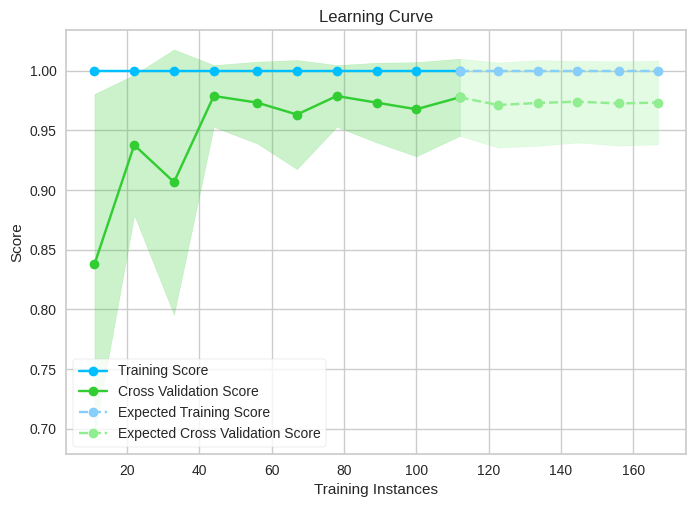

In [11]:
lc = LearningCurve(best, shuffle=True)
lc.fit(exp.X_train_transformed, exp.y_train_transformed)

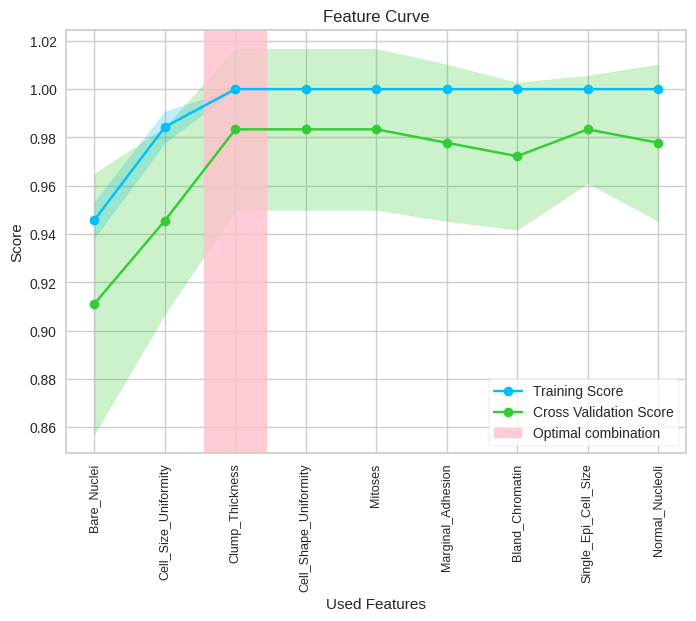

In [13]:
fc = FeatureCurve(best, n_hints=1)
fc.fit(exp.X_train_transformed, exp.y_train_transformed)

CPU times: user 1min 23s, sys: 6.43 s, total: 1min 29s
Wall time: 1min 36s


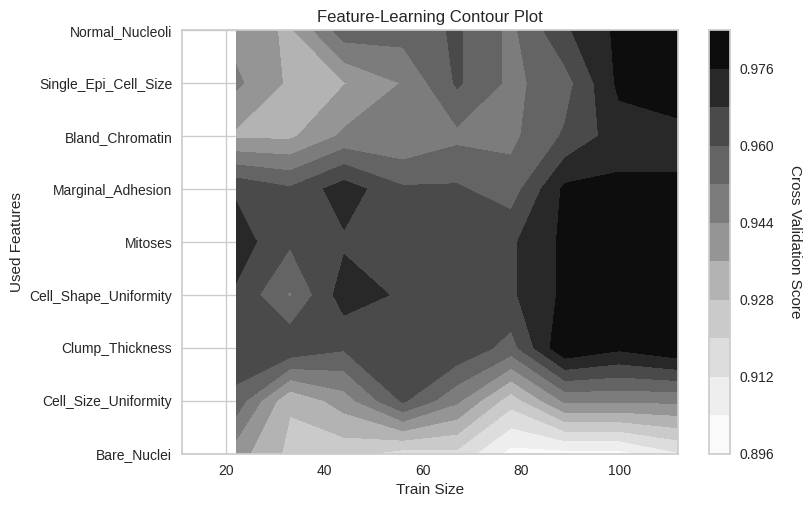

In [14]:
%%time
flc = FeatureLearningPlot(best)
flc.fit(exp.X_train_transformed, exp.y_train_transformed)

---
### TabEBM with CatBoostEncoder

In [15]:
from tabebm.TabEBM import TabEBM

In [16]:
tabebm = TabEBM(plotting=False)
augmented_data = tabebm.generate(exp.X_train_transformed.values, exp.y_train_transformed.values, num_samples=500//n_classes)

We have to download the TabPFN, as there is no checkpoint at  /usr/local/lib/python3.11/dist-packages/tabpfn/models_diff/prior_diff_real_checkpoint_n_0_epoch_42.cpkt
It has about 100MB, so this might take a moment.


In [17]:
X_syn = np.concatenate(list(augmented_data.values()))
y_syn = np.concatenate([np.full(len(augmented_data[f"class_{i}"]), i) for i in range(len(augmented_data.keys()))])
X_train_augmented = np.concatenate([exp.X_train_transformed, X_syn])
y_train_augmented = np.concatenate([exp.y_train_transformed, y_syn])

In [18]:
best.fit(exp.X_train_transformed, exp.y_train_transformed)
balanced_accuracy_score(best.predict(exp.X_test_transformed), exp.y_test_transformed)

0.9603174603174602

In [19]:
best.fit(X_train_augmented, y_train_augmented)
balanced_accuracy_score(best.predict(exp.X_test_transformed), exp.y_test_transformed)

0.9736842105263157

---
### Full data experiement

In [20]:
exp_full = ClassificationExperiment()
exp_full.setup(
    full_data,
    target='Class',
    session_id=42,
    preprocess=True,
    imputation_type='simple',
    normalize=True,
    normalize_method='zscore',
    encoding_method=CatBoostEncoder(),
    max_encoding_ohe=2,
    n_jobs=1
)

In [21]:
best_full = exp_full.compare_models(exclude=['lda', 'dummy', 'nb', 'qda'], cross_validation=True)

In [22]:
fc.features_order[:3]

Index(['Bare_Nuclei', 'Cell_Size_Uniformity', 'Clump_Thickness'], dtype='object')

In [23]:
exp_full = ClassificationExperiment()
exp_full.setup(
    data[[*fc.features_order[:3], 'Class']],
    target='Class',
    session_id=42,
    preprocess=True,
    imputation_type='simple',
    normalize=True,
    normalize_method='zscore',
    encoding_method=CatBoostEncoder(),
    max_encoding_ohe=2,
    n_jobs=1
)

In [24]:
best_full = exp_full.compare_models(exclude=['lda', 'dummy', 'nb', 'qda'], cross_validation=True)